# ULMFiT Simple Code

Sentiment Classification of US Airlines related Tweets

### Import Required Libraries

In [65]:
#loading data
import pandas as pd

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# classification report
from sklearn.metrics import classification_report, confusion_matrix

# for graphs
import matplotlib.pyplot as plt
import seaborn as sn

# FastAI for language model
from fastai import *
from fastai.text import *

In [57]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Load Data

In [74]:
'''
Data Source: https://www.kaggle.com/crowdflower/twitter-airline-sentiment
'''

'\nData Source: https://www.kaggle.com/crowdflower/twitter-airline-sentiment\n'

In [2]:
SEED = 123
BASE = '/home/basharm/.fastai/'
DATA_DIR = BASE+'data/LM_Test_Again/'
fin = 'Tweets.csv'

In [3]:
df = pd.read_csv(DATA_DIR+fin)
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Prepare Data

In [4]:
labelEncoder = LabelEncoder()

def cleanNonAscii(text):
    '''
    Remove Non ASCII characters from the dataset.
    Arguments:
        text: str
    returns: 
        text: str
    '''
    return ''.join(i for i in text if ord(i) < 128)

def gather_texts_and_labels(df=None, test_size=0.15, random_state=42):
    '''
    Gathers the text and the corresponding labels from the dataset and splits it.
    Arguments:
        df: Pandas DataFrame
        test_size: represents the test size
        random_state: represents the random state
    Returns:(x_train, x_test, y_train, y_test, new_df)
    '''
    # texts
    df['text'] = df['text'].apply(cleanNonAscii)
    texts = df["text"].values
    
    # encoding labels (positive, neutral, negative)
    df['airline_sentiment'] = labelEncoder.fit_transform(df['airline_sentiment'])
    labels = df['airline_sentiment'].values
    
    # changing the order for fastai tokenizers to capture data.
    new_df = pd.DataFrame(data={"label":labels, "text":texts})
    
    # split train test
    df_train, df_test = train_test_split(new_df, stratify = new_df['label'], 
                                         test_size=test_size, 
                                         random_state = SEED)
    # split train valid
    df_train, df_val = train_test_split(df_train, stratify = df_train['label'], 
                                        test_size = test_size,
                                        random_state = SEED)
    
    print("Training: {}, Testing: {}, Val: {}".format(len(df_train), 
                                                      len(df_test), 
                                                      len(df_val)))
    return df_train, df_test, df_val, new_df

In [5]:
df_train, df_test, df_val, new_df = gather_texts_and_labels(df)

Training: 10577, Testing: 2196, Val: 1867


# Language Model

In [6]:
# Transform data to TextLMDataBunch
data_lm = TextLMDataBunch.from_df(train_df = df_train, 
                                  valid_df = df_val, 
                                  path = DATA_DIR) # pathe is where to store the transformed data and models
# Saving the data_lm as backup
data_lm.save("data_lm_twitter.pkl") # saving as a back stop

In [8]:
# Loading the language model (AWD_LSTM)
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
print(learn_lm)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (10577 items)
x: LMTextList
xxbos @southwestair would really like my baggage from yesterday . xxmaj employees at xxmaj xxunk giving me a tough time .,xxbos @nrhodes85 : look ! xxmaj another apology . xxup do xxup not xxup fly @usairways,xxbos @americanair you need to work harder on the disconnect between your intention and the reality your passengers face,xxbos @united thanks . xxmaj just a program comment ; the system assigned seats behind each other even though xxunk were available . i changed it back .,xxbos @virginamerica xxmaj done , but i need the receipt xxup asap . xxmaj could you please help ? # xxunk - xxunk
y: LMLabelList
,,,,
Path: /home/basharm/.fastai/data/LM_Test_Again;

Valid: LabelList (1867 items)
x: LMTextList
xxbos @united 3 hours of sitting in the plane that has n't left the xxmaj gate yet . 6 more hours of actual flying left .,xxbos @jetblue , thanks for not guarantee that you can not xxunk ever my bags to my

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


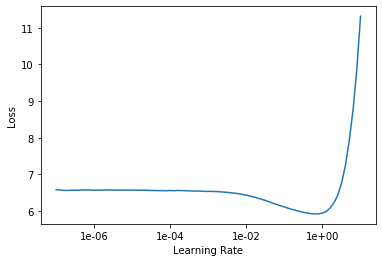

In [10]:
# Finding the optimal learning rate
learn_lm.lr_find(start_lr=1e-8, end_lr=1e2)
learn_lm.recorder.plot()

In [11]:
# Fit using one cycle policy
learn_lm.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.844904,4.134253,0.237967,00:09


In [12]:
# Unfreeze all layers
learn_lm.unfreeze()
# fit one cycle for 10 epochs
learn_lm.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.044194,3.886099,0.273600,00:12
1,3.891037,3.763363,0.287622,00:12
2,3.712503,3.677064,0.295515,00:12
3,3.498700,3.675598,0.296226,00:12
4,3.238802,3.683332,0.297037,00:13
5,2.956789,3.747706,0.296226,00:13
6,2.692710,3.811527,0.293060,00:13
7,2.470705,3.888231,0.290686,00:13
8,2.324823,3.922445,0.289468,00:13
9,2.248237,3.930788,0.289631,00:13


In [13]:
# save the fine tuned model for backup or for further fine tuning
learn_lm.save('fine_tuned_lm')

In [14]:
# save the encoder. we will need the encoder fOr classifier
learn_lm.save_encoder('fine_tuned_enc')

# Classification

In [15]:
# Preparing the classifier data
data_clas = TextClasDataBunch.from_df(path = DATA_DIR, # pathe is where to store the transformed data and models
                                      train_df = df_train, 
                                      valid_df = df_val, 
                                      test_df = df_test, 
                                      vocab=data_lm.train_ds.vocab)

In [16]:
# Building the classifier
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [17]:
print(learn_cls)

RNNLearner(data=TextClasDataBunch;

Train: LabelList (10577 items)
x: TextList
xxbos @southwestair would really like my baggage from yesterday . xxmaj employees at xxmaj xxunk giving me a tough time .,xxbos @nrhodes85 : look ! xxmaj another apology . xxup do xxup not xxup fly @usairways,xxbos @americanair you need to work harder on the disconnect between your intention and the reality your passengers face,xxbos @united thanks . xxmaj just a program comment ; the system assigned seats behind each other even though xxunk were available . i changed it back .,xxbos @virginamerica xxmaj done , but i need the receipt xxup asap . xxmaj could you please help ? # xxunk - xxunk
y: CategoryList
0,0,0,2,1
Path: /home/basharm/.fastai/data/LM_Test_Again;

Valid: LabelList (1867 items)
x: TextList
xxbos @united 3 hours of sitting in the plane that has n't left the xxmaj gate yet . 6 more hours of actual flying left .,xxbos @jetblue , thanks for not guarantee that you can not xxunk ever my bags to my 

In [18]:
# loading the saved encoder
learn_cls.load_encoder('fine_tuned_enc') # load th encoder from the LM

In [19]:
# fine tuning the whole network before unfreezing (i.e. only end layer will be updated here)
# here we will train for three epochs. we can train more as its hard to over fit here.

learn_cls.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))  

epoch,train_loss,valid_loss,accuracy,time
0,0.699244,0.565454,0.766470,00:06
1,0.618475,0.528058,0.787895,00:05
2,0.596225,0.522990,0.784146,00:06


In [20]:
# fine tuning the network layer by layer to preserve as much information is possible.

learn_cls.freeze_to(-2) # unfreeze last 2 layers
learn_cls.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7)) # slanted learning rate scheduler

epoch,train_loss,valid_loss,accuracy,time
0,0.641325,0.521069,0.787359,00:07
1,0.563088,0.494046,0.794858,00:07


In [21]:
learn_cls.freeze_to(-3) # unfreeze last 3 layers
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.541258,0.467742,0.807177,00:11
1,0.459392,0.472002,0.811998,00:11


In [22]:
learn_cls.freeze_to(-4) # unfreeze last 4 layers
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.459402,0.483114,0.813069,00:14
1,0.343559,0.466340,0.818961,00:15


In [23]:
learn_cls.freeze_to(-5) # unfreeze last 5 layers
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.359196,0.514978,0.822710,00:14
1,0.268371,0.526843,0.825388,00:14


In [24]:
# Unfreezing all the layers and training
learn_cls.unfreeze() # unfreze all
learn_cls.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.200741,0.552249,0.821103,00:14
1,0.179151,0.562201,0.825388,00:15
2,0.162827,0.586834,0.822175,00:14


### Evaluate on test dataset

In [36]:
learn_cls.predict("This was a great flight!")

(Category 2, tensor(2), tensor([6.1681e-03, 1.3195e-06, 9.9383e-01]))

In [35]:
index = learn_cls.predict("This was a great movie!")[2].numpy().argmax()
print("Predicted sentiment: {}".format(index))

Predicted sentiment: 2


In [46]:
df_test.head(2)

,label,text
2663,0,@united Thanks for nothing. Next time I'll bri...
3241,0,"@united worst airline ever! Staff is nasty, wi..."


In [48]:
predicted = [learn_cls.predict(df_test.loc[idx, 'text'])[2].numpy().argmax() for idx in df_test.index]

In [49]:
set(predicted), set(df_test['label'].to_list())

({0, 1, 2}, {0, 1, 2})

In [50]:
labels = df_test['label'].to_list()

In [51]:
print(classification_report(labels, predicted, labels=[0,1,2]))

             precision    recall  f1-score   support

          0       0.87      0.91      0.89      1377
          1       0.65      0.63      0.64       465
          2       0.80      0.72      0.76       354

avg / total       0.81      0.82      0.82      2196



In [52]:
labelEncoder.inverse_transform([0, 1, 2])

/home/basharm/.local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['negative', 'neutral', 'positive'], dtype=object)

In [59]:
'''
Confusion matrix whose i-th row and j-th column entry indicates 
the number of samples with 
true label being i-th class and prediced label being j-th class.
'''
cm = confusion_matrix(labels, predicted)
print(cm)

[[1248  101   28]
 [ 137  291   37]
 [  45   53  256]]


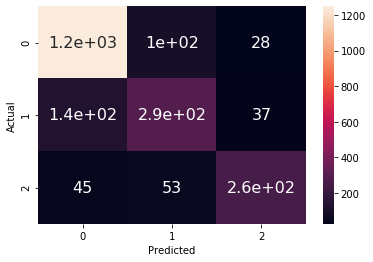

In [71]:
fig = sn.heatmap(cm, annot=True, annot_kws={"size": 16})
fig.set(xlabel='Predicted', ylabel='Actual')
plt.show()